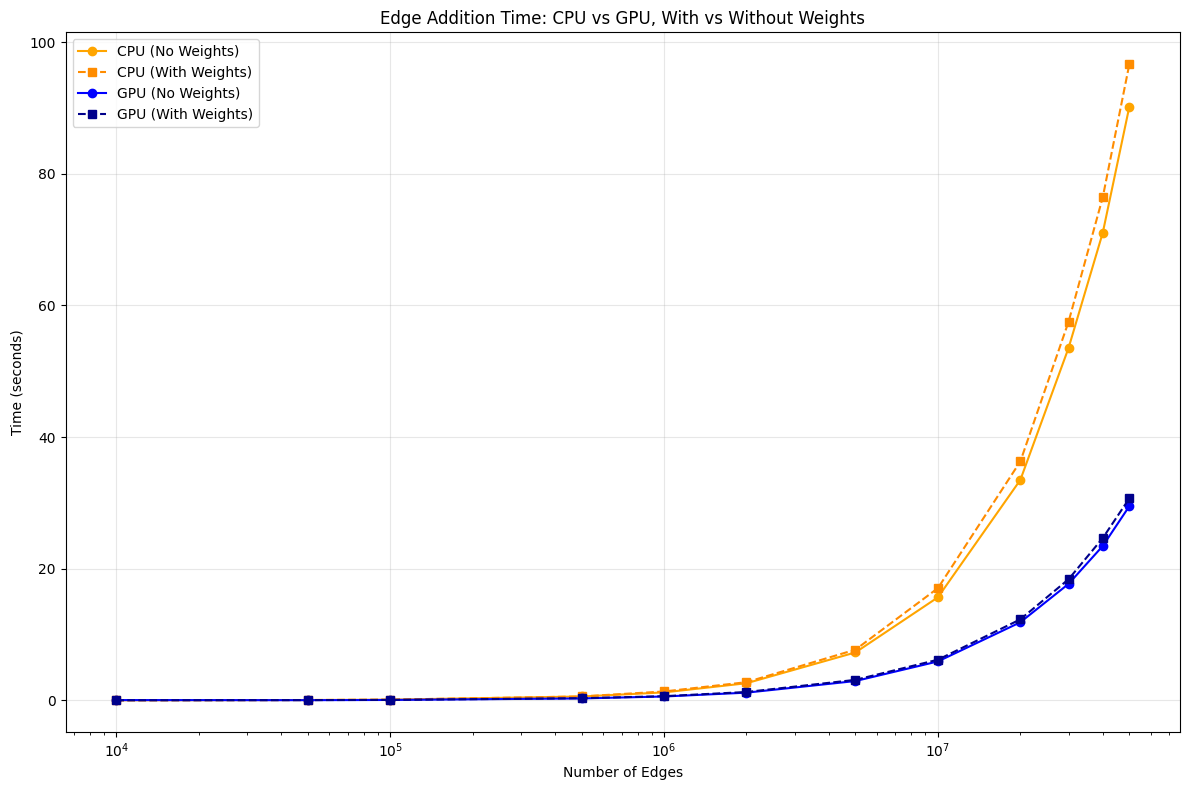

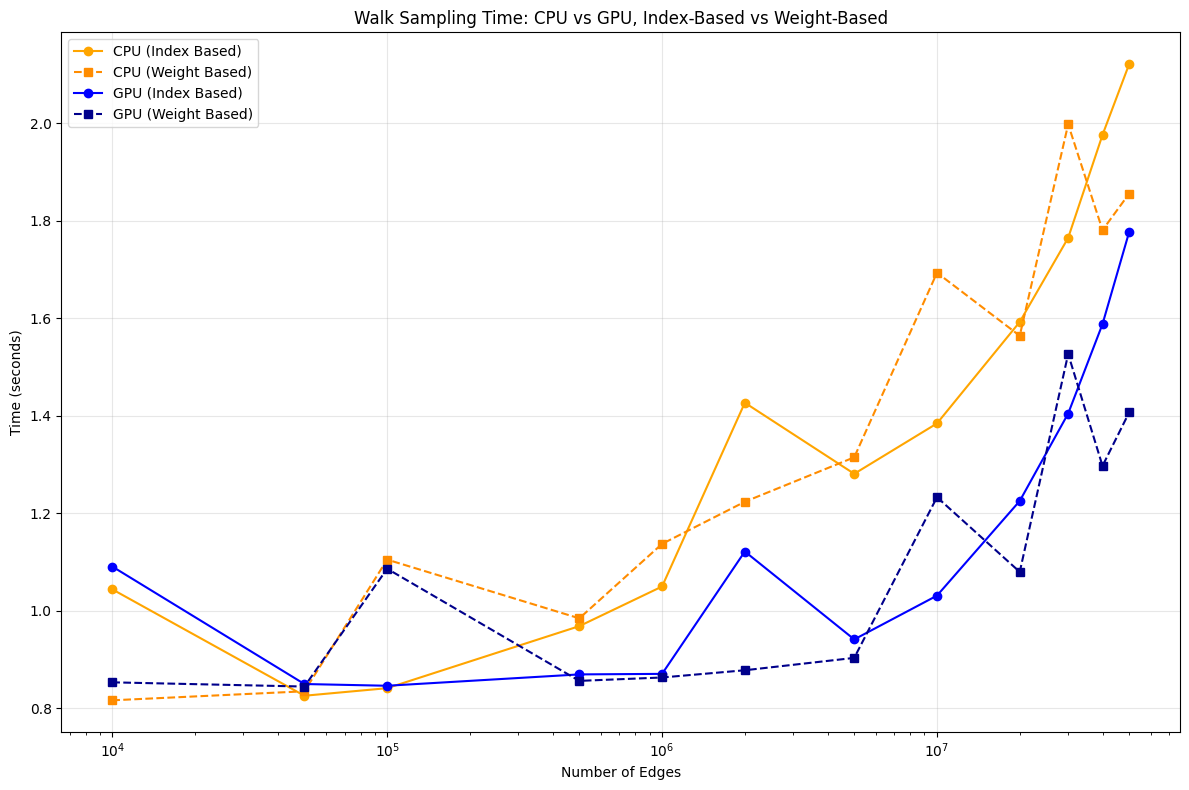

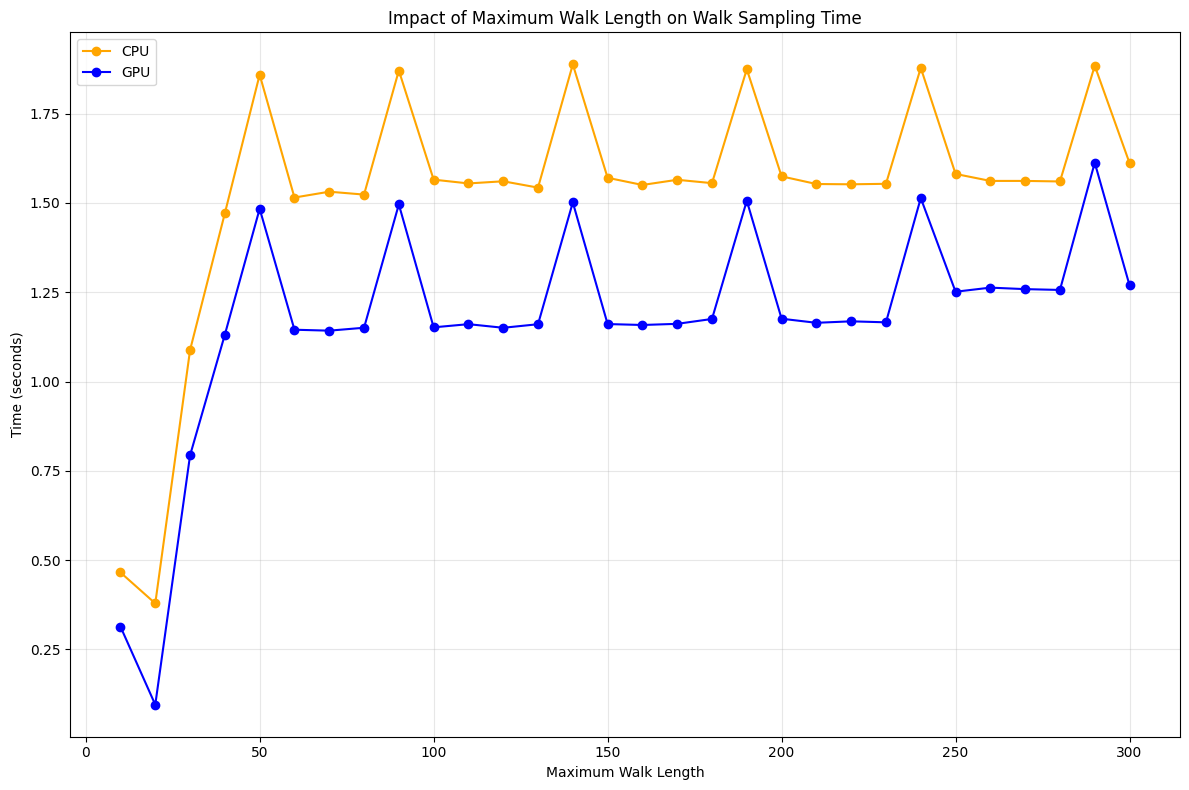

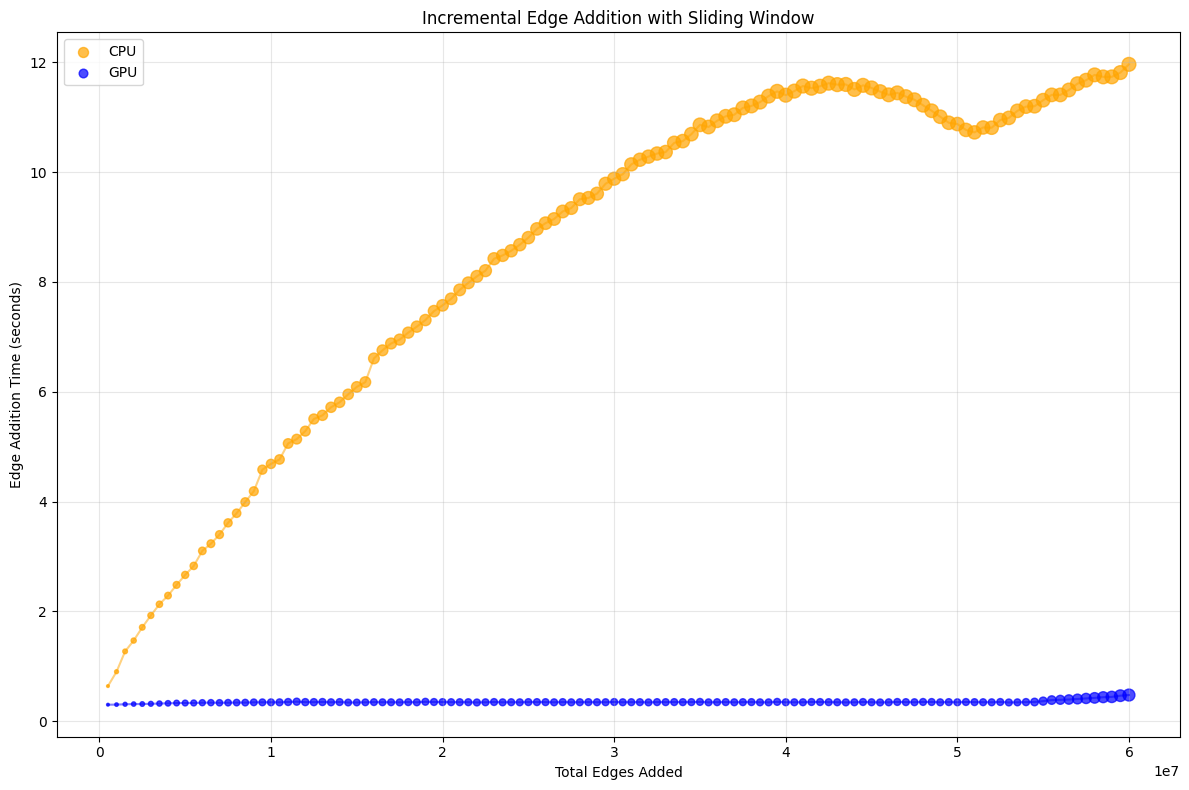

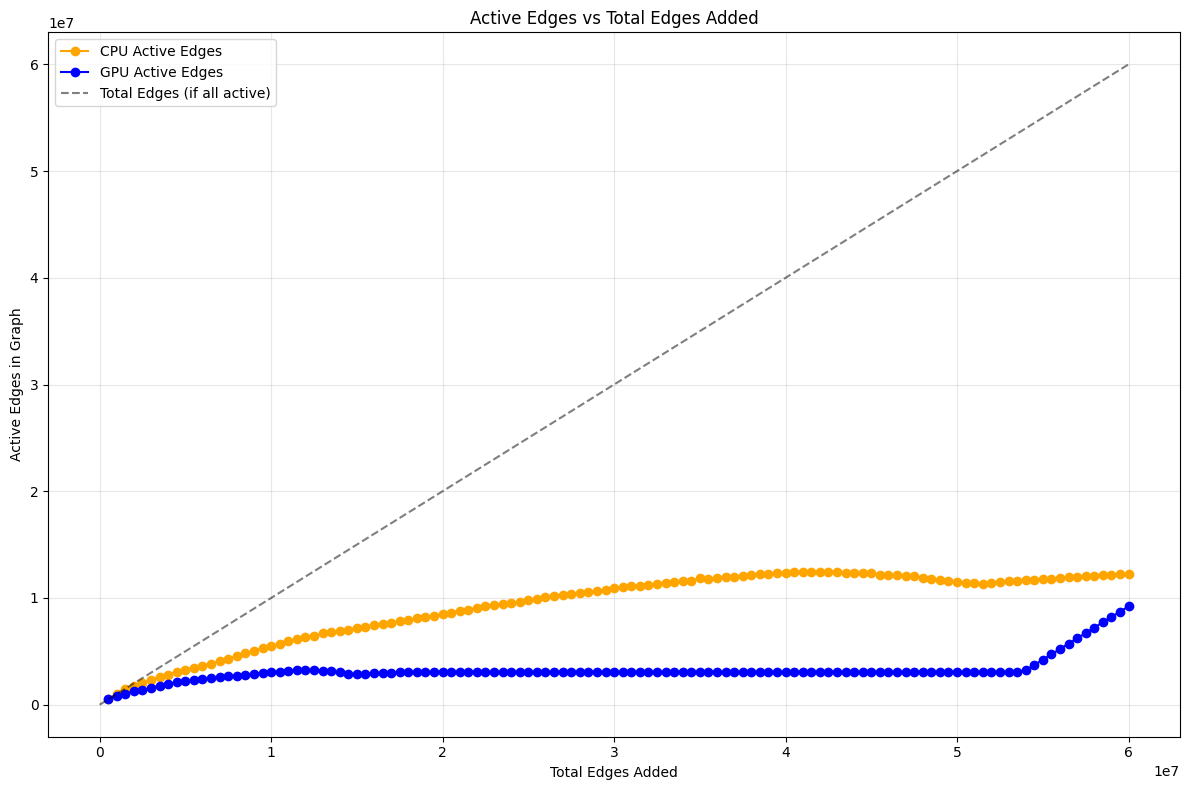

In [1]:
# Focused visualization of Temporal Walk Benchmark results
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the benchmark results
def load_results():
    cpu_results = {
        "edges": pickle.load(open("results/result_edges_CPU.pkl", "rb")),
        "walks": pickle.load(open("results/result_walks_CPU.pkl", "rb")),
        "max_walk_lens": pickle.load(open("results/result_max_walk_lens_CPU.pkl", "rb")),
        "incremental": pickle.load(open("results/result_incremental_sliding_CPU.pkl", "rb"))
    }
    
    gpu_results = {
        "edges": pickle.load(open("results/result_edges_GPU.pkl", "rb")),
        "walks": pickle.load(open("results/result_walks_GPU.pkl", "rb")),
        "max_walk_lens": pickle.load(open("results/result_max_walk_lens_GPU.pkl", "rb")),
        "incremental": pickle.load(open("results/result_incremental_sliding_GPU.pkl", "rb"))
    }
    
    return cpu_results, gpu_results

# Define edge and walk counts from the benchmark
edge_counts = [
    10_000, 50_000, 100_000, 500_000, 1_000_000, 2_000_000,
    5_000_000, 10_000_000, 20_000_000, 30_000_000, 40_000_000,
    50_000_000
]

walk_counts = [
    10_000, 50_000, 100_000, 200_000, 500_000,
    1_000_000, 2_000_000, 5_000_000
]

walk_lengths = list(range(10, 310, 10))

# Load results
cpu_results, gpu_results = load_results()

# Plot 1: Edge Addition Time - With/Without Weights, CPU vs GPU
plt.figure(figsize=(12, 8))

# CPU - No weights
plt.plot(edge_counts, cpu_results["edges"]["edge_addition_time_without_weights"], 
         'o-', color='orange', label="CPU (No Weights)")

# CPU - With weights
plt.plot(edge_counts, cpu_results["edges"]["edge_addition_time_with_weights"], 
         's--', color='darkorange', label="CPU (With Weights)")

# GPU - No weights
plt.plot(edge_counts, gpu_results["edges"]["edge_addition_time_without_weights"], 
         'o-', color='blue', label="GPU (No Weights)")

# GPU - With weights
plt.plot(edge_counts, gpu_results["edges"]["edge_addition_time_with_weights"], 
         's--', color='darkblue', label="GPU (With Weights)")

plt.xscale('log')
plt.xlabel("Number of Edges")
plt.ylabel("Time (seconds)")
plt.title("Edge Addition Time: CPU vs GPU, With vs Without Weights")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot1_edge_addition_comparison.png")
plt.show()

# Plot 2: Walk Sampling Time - With/Without Weights, CPU vs GPU
plt.figure(figsize=(12, 8))

# CPU - Index based
plt.plot(edge_counts, cpu_results["edges"]["walk_sampling_time_index_based"], 
         'o-', color='orange', label="CPU (Index Based)")

# CPU - Weight based
plt.plot(edge_counts, cpu_results["edges"]["walk_sampling_time_weight_based"], 
         's--', color='darkorange', label="CPU (Weight Based)")

# GPU - Index based
plt.plot(edge_counts, gpu_results["edges"]["walk_sampling_time_index_based"], 
         'o-', color='blue', label="GPU (Index Based)")

# GPU - Weight based
plt.plot(edge_counts, gpu_results["edges"]["walk_sampling_time_weight_based"], 
         's--', color='darkblue', label="GPU (Weight Based)")

plt.xscale('log')
plt.xlabel("Number of Edges")
plt.ylabel("Time (seconds)")
plt.title("Walk Sampling Time: CPU vs GPU, Index-Based vs Weight-Based")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot2_walk_sampling_comparison.png")
plt.show()

# Plot 3: Walk Length Impact (Index-based only)
plt.figure(figsize=(12, 8))

# CPU walk sampling time
plt.plot(walk_lengths, cpu_results["max_walk_lens"]["walk_sampling_time"], 
         'o-', color='orange', label="CPU")

# GPU walk sampling time
plt.plot(walk_lengths, gpu_results["max_walk_lens"]["walk_sampling_time"], 
         'o-', color='blue', label="GPU")

plt.xlabel("Maximum Walk Length")
plt.ylabel("Time (seconds)")
plt.title("Impact of Maximum Walk Length on Walk Sampling Time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot3_walk_length_impact.png")
plt.show()

# Plot 4: Incremental Edge Addition with Active Edges
plt.figure(figsize=(12, 8))

# Create scatter plots with size indicating active edges
cpu_total_edges = cpu_results["incremental"]["total_edges"]
cpu_active_edges = cpu_results["incremental"]["active_edges"]
cpu_edge_addition_time = cpu_results["incremental"]["edge_addition_time"]

gpu_total_edges = gpu_results["incremental"]["total_edges"]
gpu_active_edges = gpu_results["incremental"]["active_edges"]
gpu_edge_addition_time = gpu_results["incremental"]["edge_addition_time"]

# Calculate normalized size for scatter points
max_active = max(max(cpu_active_edges), max(gpu_active_edges))
cpu_sizes = [100 * active / max_active for active in cpu_active_edges]
gpu_sizes = [100 * active / max_active for active in gpu_active_edges]

# Plot the data
sc_cpu = plt.scatter(cpu_total_edges, cpu_edge_addition_time, 
                     s=cpu_sizes, c='orange', alpha=0.7, label="CPU")
sc_gpu = plt.scatter(gpu_total_edges, gpu_edge_addition_time, 
                     s=gpu_sizes, c='blue', alpha=0.7, label="GPU")

# Add lines to connect points
plt.plot(cpu_total_edges, cpu_edge_addition_time, 'orange', alpha=0.5)
plt.plot(gpu_total_edges, gpu_edge_addition_time, 'blue', alpha=0.5)

plt.xlabel("Total Edges Added")
plt.ylabel("Edge Addition Time (seconds)")
plt.title("Incremental Edge Addition with Sliding Window")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot4_incremental_edge_addition.png")
plt.show()

plt.figure(figsize=(12, 8))

# Plot active edges vs total edges
plt.plot(cpu_total_edges, cpu_active_edges, 'o-', color='orange', label="CPU Active Edges")
plt.plot(gpu_total_edges, gpu_active_edges, 'o-', color='blue', label="GPU Active Edges")

# Add a reference line showing total edges (y=x line)
max_total = max(max(cpu_total_edges), max(gpu_total_edges))
plt.plot([0, max_total], [0, max_total], 'k--', alpha=0.5, label="Total Edges (if all active)")

plt.xlabel("Total Edges Added")
plt.ylabel("Active Edges in Graph")
plt.title("Active Edges vs Total Edges Added")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/plot5_total_vs_active_edges.png")
plt.show()